## Purpose of this notebook

- load the G terms we created for the whole Barents Sea
- see overall climatology for one year
- see if we can look at overall trends for this for an example in the timeseries (is there a particular month which trends up?)
- can we see anything else interesting?

In [12]:
# load the packages and functions

# auto-reload edited moduleås
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import matplotlib.dates as mdates
from itertools import cycle

In [14]:
path = "/scratch/mmurakami/ASTE_270/ASTER1_offline_terms/"
fn = path + "wmt_gates_monthly_and_climatology_2006_2017_BarentsS.npz"

with np.load(fn, allow_pickle=True) as D:
    out  = D["out"].item()   # dict keyed by ts_key
    clim = D["clim"].item()  # dict with "meta" and "monthly"

# examples
print(type(out), len(out))
print(clim["meta"].keys())
print(clim["monthly"][1].keys())  # January fields

<class 'dict'> 144
dict_keys(['years', 'gateT_keys', 'gateS_keys'])
dict_keys(['GT', 'GS', 'gatesT', 'gatesS', 'Tbudg', 'Sbudg'])


In [15]:
# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))


# 01.22.26: define another gateway midpoint, need to include this in gate functions and add a flag to the gates_check function

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


In [4]:
# out

## plot the long term timeseries to show that this is closed:

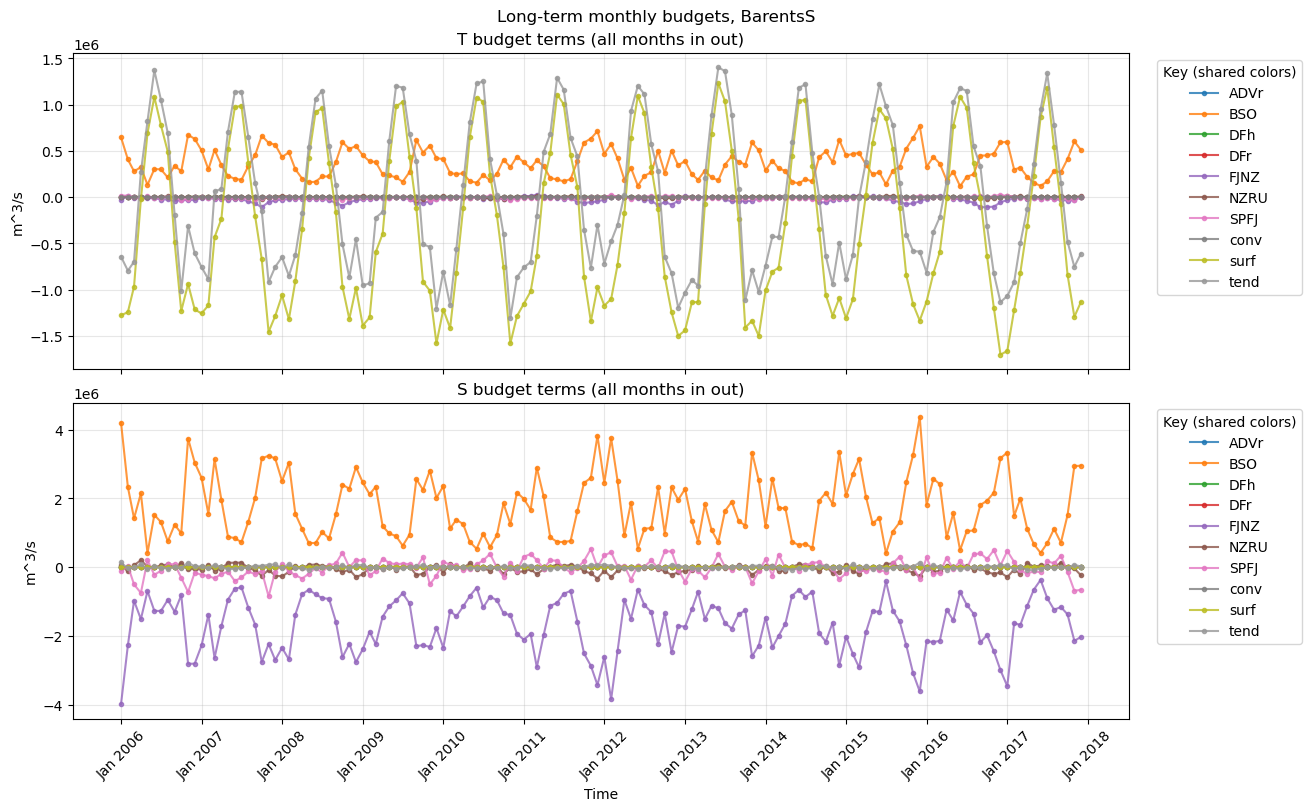

In [5]:
# --- build time axis from out metadata, sorted chronologically ---
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])  # month labels

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))  # reduce arrays to scalar
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# drop ADVh and residuals from BOTH
drop_terms = lambda k: is_advh(k) or is_residual(k)

T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# --- consistent color mapping across both plots (after dropping) ---
all_keys_union = sorted(set(T_keys).union(S_keys))

from itertools import cycle

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

key_to_color = {}
for k in all_keys_union:
    if is_tendency(k):
        key_to_color[k] = "0.6"  # gray

remaining = [k for k in all_keys_union if k not in key_to_color]
cycler = cycle(palette12)
for k in remaining:
    key_to_color[k] = next(cycler)

fig, (axT, axS) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)

# --- Tbudg (top) ---
for k, y in T_vals.items():
    axT.plot(x, y, marker=".", label=str(k), alpha=0.8, color=key_to_color[k])
axT.set_ylabel("m^3/s")
axT.set_title("T budget terms (all months in out)")
axT.grid(alpha=0.3)
axT.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# --- Sbudg (bottom) ---
for k, y in S_vals.items():
    axS.plot(x, y, marker=".", label=str(k), alpha=0.8, color=key_to_color[k])
axS.set_ylabel("m^3/s")
axS.set_title("S budget terms (all months in out)")
axS.grid(alpha=0.3)
axS.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# x-axis formatting (tick every year)
axS.set_xlabel("Time")
axS.xaxis.set_major_locator(mdates.YearLocator(base=1))
axS.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="center")

plt.suptitle("Long-term monthly budgets, BarentsS")
plt.show()


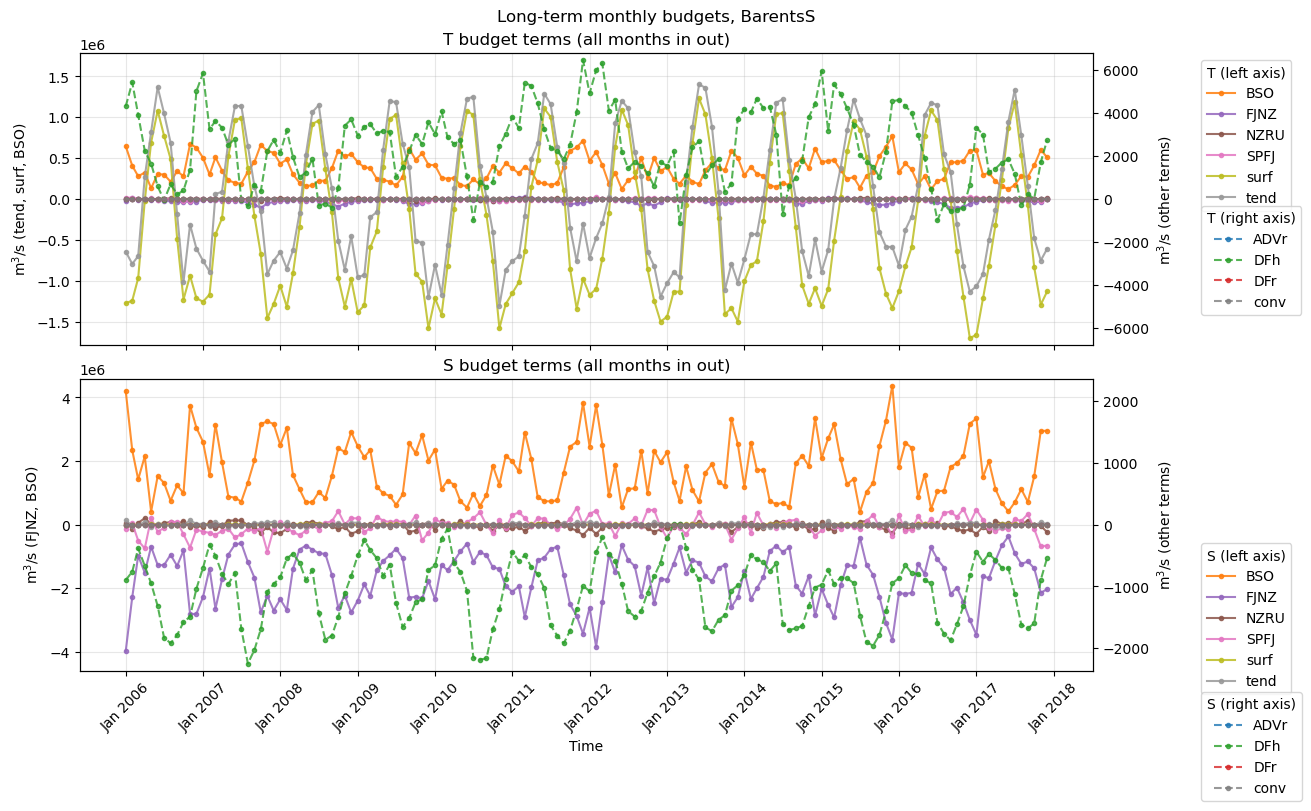

In [6]:
# plot these on separate axes to zoom in

# --- build time axis from out metadata, sorted chronologically ---
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])  # month labels

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))  # reduce arrays to scalar
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# drop ADVh and residuals from BOTH
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# --- consistent color mapping across both plots (after dropping) ---
all_keys_union = sorted(set(T_keys).union(S_keys))

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

key_to_color = {}
for k in all_keys_union:
    if is_tendency(k):
        key_to_color[k] = "0.6"  # gray

remaining = [k for k in all_keys_union if k not in key_to_color]
cycler = cycle(palette12)
for k in remaining:
    key_to_color[k] = next(cycler)

# -------- axis assignment rules --------
T_left = {"tend", "surf", "SPFJ","BSO","FJNZ","NZRU"}   # temperature: left axis terms
S_left = {"tend","surf","NZRU","SPFJ","FJNZ", "BSO"}           # salinity: left axis terms

fig, (axT_L, axS_L) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)

axT_R = axT_L.twinx()
axS_R = axS_L.twinx()

# --- Tbudg (top): left vs right axis ---
for k, y in T_vals.items():
    if k in T_left:
        axT_L.plot(x, y, marker=".", label=str(k),
                   alpha=0.85, color=key_to_color.get(k, None), linestyle="-")
    else:
        axT_R.plot(x, y, marker=".", label=str(k),
                   alpha=0.80, color=key_to_color.get(k, None), linestyle="--")

axT_L.set_ylabel("m$^3$/s (tend, surf, BSO)")
axT_R.set_ylabel("m$^3$/s (other terms)")
axT_L.set_title("T budget terms (all months in out)")
axT_L.grid(alpha=0.3)

# --- Sbudg (bottom): left vs right axis ---
for k, y in S_vals.items():
    if k in S_left:
        axS_L.plot(x, y, marker=".", label=str(k),
                   alpha=0.85, color=key_to_color.get(k, None), linestyle="-")
    else:
        axS_R.plot(x, y, marker=".", label=str(k),
                   alpha=0.80, color=key_to_color.get(k, None), linestyle="--")

axS_L.set_ylabel("m$^3$/s (FJNZ, BSO)")
axS_R.set_ylabel("m$^3$/s (other terms)")
axS_L.set_title("S budget terms (all months in out)")
axS_L.grid(alpha=0.3)

# x-axis formatting (tick every year)
axS_L.set_xlabel("Time")
axS_L.xaxis.set_major_locator(mdates.YearLocator(base=1))
axS_L.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="center")

# legends outside (separate left/right)
axT_L.legend(title="T (left axis)",  bbox_to_anchor=(1.1, 1.0), loc="upper left")
axT_R.legend(title="T (right axis)", bbox_to_anchor=(1.1, 0.5), loc="upper left")
axS_L.legend(title="S (left axis)",  bbox_to_anchor=(1.1, 0.46), loc="upper left")
axS_R.legend(title="S (right axis)", bbox_to_anchor=(1.1, -0.05), loc="upper left")

# set symmetric axes
def set_symmetric_ylim(ax, pad=1.05):
    ys = []
    for line in ax.get_lines():
        y = np.asarray(line.get_ydata(), dtype=float)
        ys.append(y[np.isfinite(y)])
    if not ys:
        return
    ymax = np.nanmax(np.abs(np.concatenate(ys)))
    if ymax == 0 or not np.isfinite(ymax):
        ymax = 1.0
    ax.set_ylim(-pad * ymax, pad * ymax)

# ... after plotting into axT_L, axT_R, axS_L, axS_R:
set_symmetric_ylim(axT_L)
set_symmetric_ylim(axT_R)
set_symmetric_ylim(axS_L)
set_symmetric_ylim(axS_R)

plt.suptitle("Long-term monthly budgets, BarentsS")
plt.show()


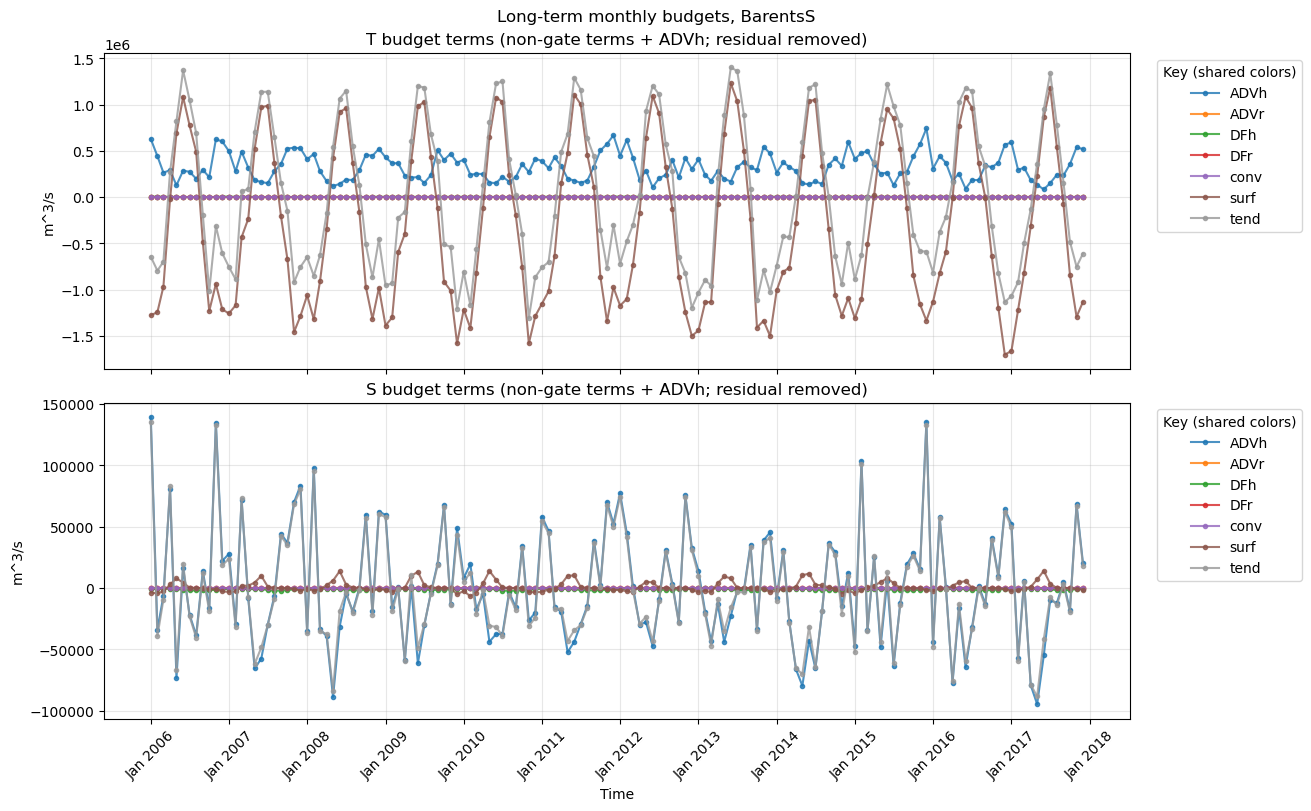

In [7]:
# show this same figure but remove the gates for both and plot with ADVh


# --- build time axis from out metadata, sorted chronologically ---
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])  # month labels

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

# ---- filters ----
def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

# "gates" heuristic: drop anything that looks like a gate series
# (keeps ADVh even if it contains 'advh')
_gate_tokens = ("gate", "bso", "sfj", "fj", "nzd", "nz", "ru", "fram", "bering", "davis", "denmark", "nares")
def is_gate(k):
    s = _norm_key(k)
    return any(tok in s for tok in _gate_tokens)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))  # reduce arrays to scalar
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# drop gates + residuals; KEEP ADVh
drop_terms = lambda k: is_gate(k) or is_residual(k)

T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# --- consistent color mapping across both plots ---
all_keys_union = sorted(set(T_keys).union(S_keys))

from itertools import cycle

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

key_to_color = {}
for k in all_keys_union:
    if is_tendency(k):
        key_to_color[k] = "0.6"  # gray

remaining = [k for k in all_keys_union if k not in key_to_color]
cycler = cycle(palette12)
for k in remaining:
    key_to_color[k] = next(cycler)

fig, (axT, axS) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)

# --- Tbudg (top) ---
for k, y in T_vals.items():
    axT.plot(x, y, marker=".", label=str(k), alpha=0.8, color=key_to_color[k])
axT.set_ylabel("m^3/s")
axT.set_title("T budget terms (non-gate terms + ADVh; residual removed)")
axT.grid(alpha=0.3)
axT.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# --- Sbudg (bottom) ---
for k, y in S_vals.items():
    axS.plot(x, y, marker=".", label=str(k), alpha=0.8, color=key_to_color[k])
axS.set_ylabel("m^3/s")
axS.set_title("S budget terms (non-gate terms + ADVh; residual removed)")
axS.grid(alpha=0.3)
axS.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# x-axis formatting (tick every year)
axS.set_xlabel("Time")
axS.xaxis.set_major_locator(mdates.YearLocator(base=1))
axS.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="center")

plt.suptitle("Long-term monthly budgets, BarentsS")
plt.show()


In [8]:
# for the deseasoned version I think we should include months before and after





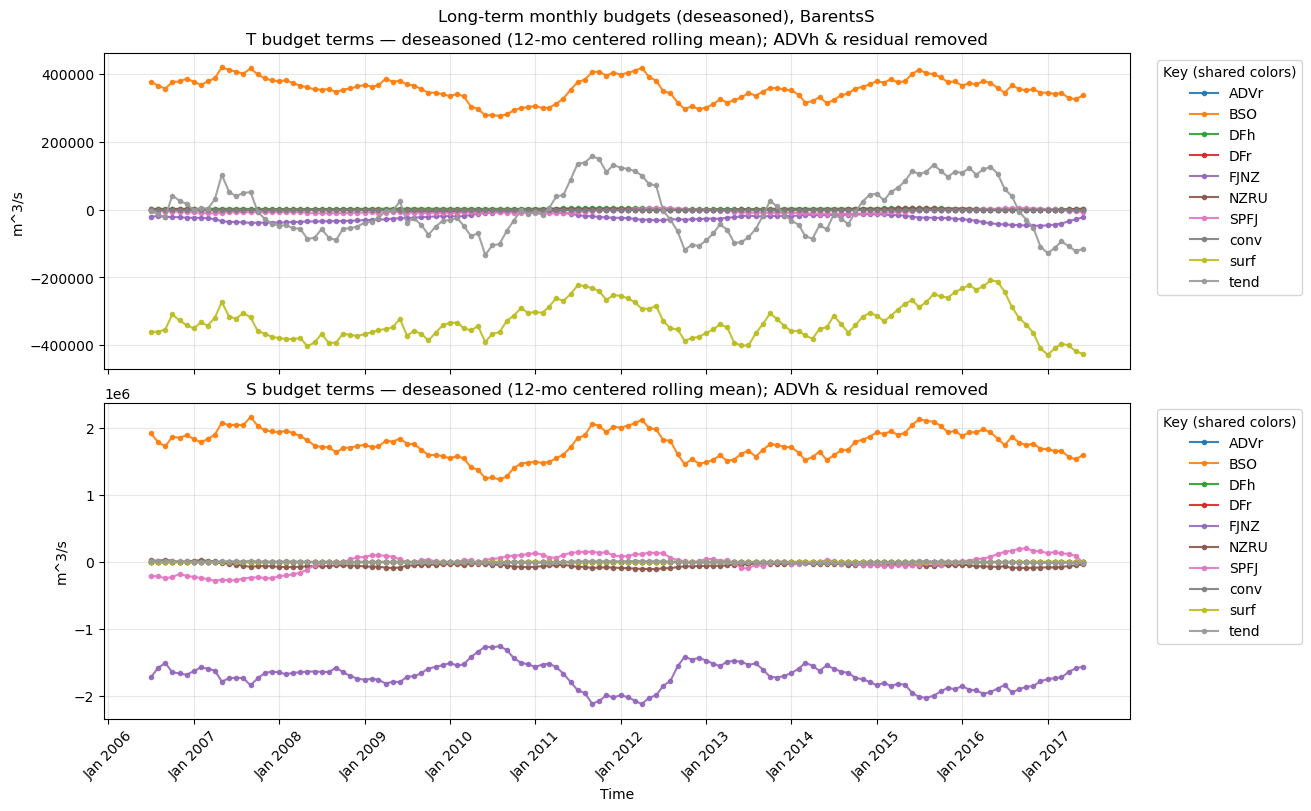

In [9]:
# now create a de-seasoned cycle of this term

# --- build time axis from out metadata, sorted chronologically ---
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])  # month labels

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))  # reduce arrays to scalar
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# drop ADVh and residuals from BOTH
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# --- consistent color mapping across both plots (after dropping) ---
all_keys_union = sorted(set(T_keys).union(S_keys))
from itertools import cycle

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

key_to_color = {}
for k in all_keys_union:
    if is_tendency(k):
        key_to_color[k] = "0.6"  # gray

remaining = [k for k in all_keys_union if k not in key_to_color]
cycler = cycle(palette12)
for k in remaining:
    key_to_color[k] = next(cycler)

# --- deseason via centered 12-month rolling mean ---
window_size = 12
def deseason_rolling(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    return s.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

fig, (axT, axS) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)

# --- Tbudg (top): deseasoned (rolling-mean) series ---
for k, y in T_vals.items():
    y_ds = deseason_rolling(y, x)
    axT.plot(x[6:-6], y_ds[6:-6], marker=".", label=str(k), alpha=0.9, color=key_to_color[k])
axT.set_ylabel("m^3/s")
axT.set_title("T budget terms — deseasoned (12-mo centered rolling mean); ADVh & residual removed")
axT.grid(alpha=0.3)
axT.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# --- Sbudg (bottom): deseasoned (rolling-mean) series ---
for k, y in S_vals.items():
    y_ds = deseason_rolling(y, x)
    axS.plot(x[6:-6], y_ds[6:-6], marker=".", label=str(k), alpha=0.9, color=key_to_color[k])
axS.set_ylabel("m^3/s")
axS.set_title("S budget terms — deseasoned (12-mo centered rolling mean); ADVh & residual removed")
axS.grid(alpha=0.3)
axS.legend(title="Key (shared colors)", bbox_to_anchor=(1.02, 1), loc="upper left")

# x-axis formatting (tick every year)
axS.set_xlabel("Time")
axS.xaxis.set_major_locator(mdates.YearLocator(base=1))
axS.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="center")

plt.suptitle("Long-term monthly budgets (deseasoned), BarentsS")
plt.show()


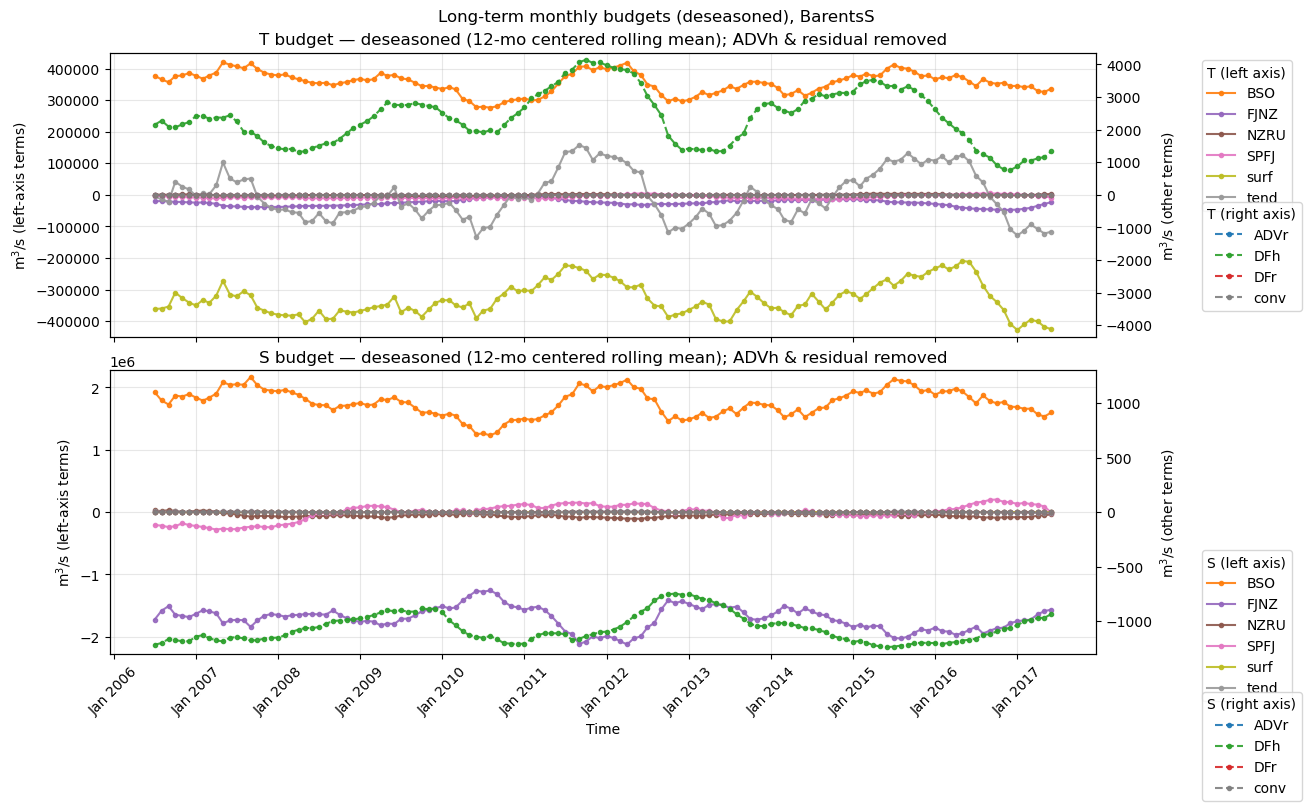

In [10]:
# ---------------------------------------
# build time axis from out metadata
# ---------------------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()

ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])  # month labels

def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def collect_series(budg_name, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            if np.ndim(v) > 0:
                v = np.nansum(np.asarray(v, dtype=float))  # reduce arrays to scalar
            y.append(v)
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# drop ADVh and residuals from BOTH
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys, T_vals = collect_series("Tbudg", drop_fn=drop_terms)
S_keys, S_vals = collect_series("Sbudg", drop_fn=drop_terms)

# ---------------------------------------
# consistent colors across both plots
# ---------------------------------------
all_keys_union = sorted(set(T_keys).union(S_keys))

palette12 = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728",
    "#9467bd", "#8c564b", "#e377c2", "#7f7f7f",
    "#bcbd22", "#17becf", "#393b79", "#637939",
]

def is_tendency(k):
    s = _norm_key(k)
    return ("tend" in s) or ("tendency" in s) or ("ddt" in s) or (s.startswith("dt"))

key_to_color = {}
for k in all_keys_union:
    if is_tendency(k):
        key_to_color[k] = "0.6"  # gray

remaining = [k for k in all_keys_union if k not in key_to_color]
cycler = cycle(palette12)
for k in remaining:
    key_to_color[k] = next(cycler)

# ---------------------------------------
# deseason via centered 12-month rolling mean
# (and crop 6 months on each end)
# ---------------------------------------
window_size = 12
def deseason_rolling(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    return s.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

# ---------------------------------------
# axis assignment rules (same as your "zoom" figure)
# ---------------------------------------
T_left = {"tend", "surf", "SPFJ", "BSO", "FJNZ", "NZRU"}
S_left = {"tend", "surf", "NZRU", "SPFJ", "FJNZ", "BSO"}

# ---------------------------------------
# symmetric y-lims helper (per axis)
# ---------------------------------------
def set_symmetric_ylim(ax, pad=1.05):
    ys = []
    for line in ax.get_lines():
        y = np.asarray(line.get_ydata(), dtype=float)
        ys.append(y[np.isfinite(y)])
    if not ys:
        return
    ymax = np.nanmax(np.abs(np.concatenate(ys)))
    if ymax == 0 or not np.isfinite(ymax):
        ymax = 1.0
    ax.set_ylim(-pad * ymax, pad * ymax)

# ---------------------------------------
# plotting
# ---------------------------------------
fig, (axT_L, axS_L) = plt.subplots(2, 1, figsize=(13, 8), sharex=True, constrained_layout=True)
axT_R = axT_L.twinx()
axS_R = axS_L.twinx()

# crop to avoid edge artifacts from centered rolling mean
sl = slice(6, -6)

# --- Tbudg (top): deseasoned; left vs right axis ---
for k, y in T_vals.items():
    y_ds = deseason_rolling(y, x)
    if k in T_left:
        axT_L.plot(x[sl], y_ds[sl], marker=".", label=str(k),
                   alpha=0.9, color=key_to_color.get(k, None), linestyle="-")
    else:
        axT_R.plot(x[sl], y_ds[sl], marker=".", label=str(k),
                   alpha=0.9, color=key_to_color.get(k, None), linestyle="--")

axT_L.set_ylabel("m$^3$/s (left-axis terms)")
axT_R.set_ylabel("m$^3$/s (other terms)")
axT_L.set_title("T budget — deseasoned (12-mo centered rolling mean); ADVh & residual removed")
axT_L.grid(alpha=0.3)

# --- Sbudg (bottom): deseasoned; left vs right axis ---
for k, y in S_vals.items():
    y_ds = deseason_rolling(y, x)
    if k in S_left:
        axS_L.plot(x[sl], y_ds[sl], marker=".", label=str(k),
                   alpha=0.9, color=key_to_color.get(k, None), linestyle="-")
    else:
        axS_R.plot(x[sl], y_ds[sl], marker=".", label=str(k),
                   alpha=0.9, color=key_to_color.get(k, None), linestyle="--")

axS_L.set_ylabel("m$^3$/s (left-axis terms)")
axS_R.set_ylabel("m$^3$/s (other terms)")
axS_L.set_title("S budget — deseasoned (12-mo centered rolling mean); ADVh & residual removed")
axS_L.grid(alpha=0.3)

# x-axis formatting (tick every year)
axS_L.set_xlabel("Time")
axS_L.xaxis.set_major_locator(mdates.YearLocator(base=1))
axS_L.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
fig.autofmt_xdate(rotation=45, ha="center")

# legends outside (separate left/right)
axT_L.legend(title="T (left axis)",  bbox_to_anchor=(1.1, 1.0), loc="upper left")
axT_R.legend(title="T (right axis)", bbox_to_anchor=(1.1, 0.5), loc="upper left")
axS_L.legend(title="S (left axis)",  bbox_to_anchor=(1.1, 0.39), loc="upper left")
axS_R.legend(title="S (right axis)", bbox_to_anchor=(1.1, -0.11), loc="upper left")

# symmetric y-lims on each axis
set_symmetric_ylim(axT_L)
set_symmetric_ylim(axT_R)
set_symmetric_ylim(axS_L)
set_symmetric_ylim(axS_R)

plt.suptitle("Long-term monthly budgets (deseasoned), BarentsS")
plt.show()

# now contextualize the years we have within the context of the climatology

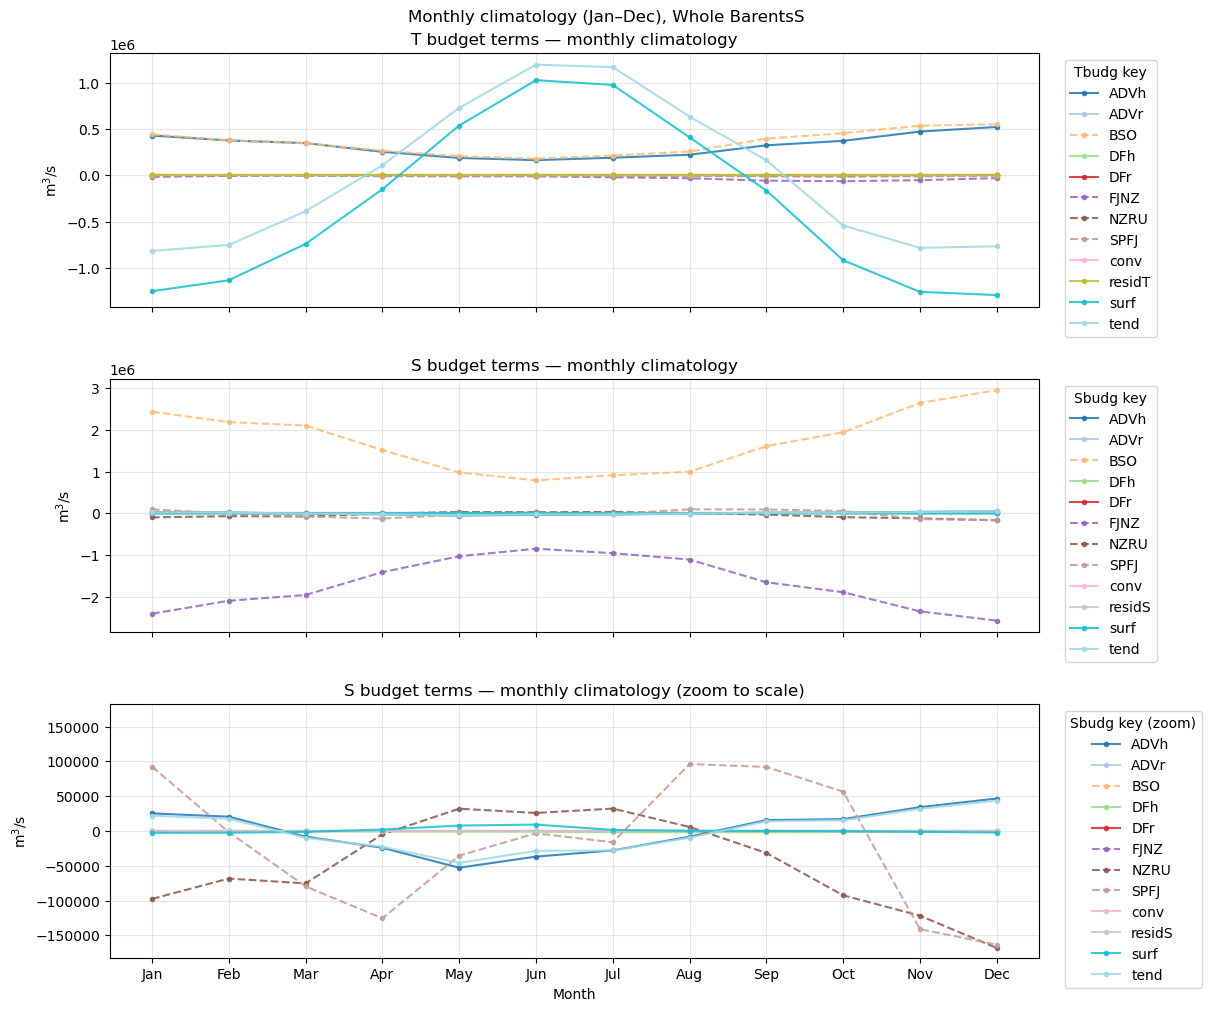

In [11]:
# --- build sorted monthly axis from out metadata ---
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()
ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

months = np.arange(1, 13)
month_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

gate_keys = {"BSO", "FJNZ", "SPFJ", "NZRU"}

def _as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

def collect_series(budg_name):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    vals_by_key = {}
    for k in all_keys:
        vals_by_key[k] = np.asarray(
            [_as_scalar(out[ts].get(budg_name, {}).get(k, np.nan)) for ts in ts_sorted],
            dtype=float
        )
    return all_keys, vals_by_key

T_keys, T_vals = collect_series("Tbudg")
S_keys, S_vals = collect_series("Sbudg")

def monthly_clim_vector(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    clim = s.groupby(s.index.month).mean()  # 1..12
    return clim.reindex(months).to_numpy()

T_clim = {k: monthly_clim_vector(v, x) for k, v in T_vals.items()}
S_clim = {k: monthly_clim_vector(v, x) for k, v in S_vals.items()}

# ---- consistent unique colors across ALL terms (T ∪ S)
all_terms = sorted(set(T_clim.keys()).union(S_clim.keys()))
cmap = plt.cm.tab20
colors = {k: cmap(i / max(1, len(all_terms) - 1)) for i, k in enumerate(all_terms)}

def plot_terms(ax, clim_dict, title):
    for k, y in clim_dict.items():
        ls = "--" if k in gate_keys else "-"
        ax.plot(months, y, marker=".", label=str(k), alpha=0.85, color=colors[k], linestyle=ls)
    ax.set_ylabel("m$^3$/s")
    ax.set_title(title)
    ax.grid(alpha=0.3)

fig, (axT, axS, axS_zoom) = plt.subplots(3, 1, figsize=(12, 10), sharex=True, constrained_layout=True)

# --- T climatology (Jan..Dec) ---
plot_terms(axT, T_clim, "T budget terms — monthly climatology")

# --- S climatology (Jan..Dec) ---
plot_terms(axS, S_clim, "S budget terms — monthly climatology")

# --- zoomed S climatology (same curves, clipped to DFr scale) ---
plot_terms(axS_zoom, S_clim, "S budget terms — monthly climatology (zoom to scale)")

# set y-limits on third subplot using nanmax of DFr (abs)
dfr = S_clim.get("DFh", None)
if dfr is None:
    raise KeyError("S_clim does not contain 'DFr' (needed to set zoom y-limits).")
dfr_max = float(np.nanmax(np.abs(dfr)))*100
if not np.isfinite(dfr_max) or dfr_max == 0:
    dfr_max = 1.0
axS_zoom.set_ylim(-dfr_max, dfr_max)

# x-axis month labels on bottom subplot
axS_zoom.set_xticks(months)
axS_zoom.set_xticklabels(month_labels)
axS_zoom.set_xlabel("Month")

# legends outside
axT.legend(title="Tbudg key", bbox_to_anchor=(1.02, 1), loc="upper left")
axS.legend(title="Sbudg key", bbox_to_anchor=(1.02, 1), loc="upper left")
axS_zoom.legend(title="Sbudg key (zoom)", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.suptitle("Monthly climatology (Jan–Dec), Whole BarentsS")
plt.show()

# I think it would be good to make a refinement of the previous figure to add in the ocean heat content and sea ice extent

We can include this on top of the plot of just the T tend, BSO, and surface contributions

In [12]:
# let's grab the ocn. heat content and the sea ice extent as an avg. of J-M
# I think we can just do this for the northern portion (ie mymsk2)

(400.0, 600.0)

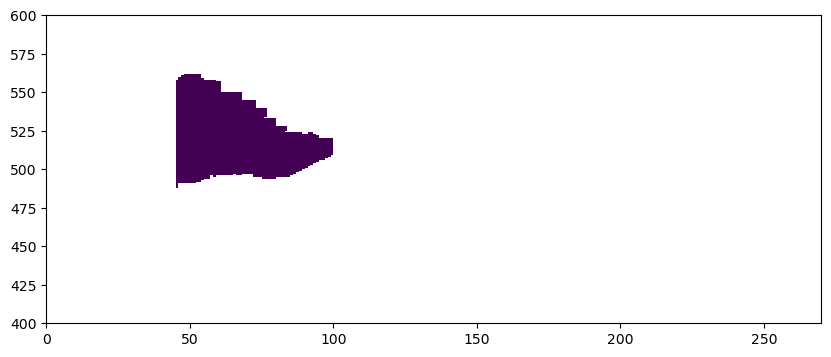

In [13]:
mymsk2 = np.full((ny,nx),np.nan)
mymsk2[mymsk == 1] = 1
mymsk2[:,:45] = np.nan
mymsk2[:,100:] = np.nan

plt.pcolormesh(mymsk2)
plt.ylim(400,600)

In [14]:
# get the timesteps for the year 2007
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [15]:
heat_content = np.full((len(allyears),12,ny,nx),np.nan)

In [12]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name
dstart = 0
dterm = 10

# sref = 36.25
# tref = -1.95

# from Lind Paper
sref = 35
tref = 0

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETA = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_3d_set1'
        meta_state_3d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_3d_set1["fldList"])
        varnames = np.array(["THETA","SALT"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETAi,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        #SALTi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETA[i,:,:,:] = np.reshape(THETAi,(nz,ny,nx)) #/ hfC_modified   # degC
        #SALT[i,:,:,:] = np.reshape(SALTi,(nz,ny,nx)) / hfC_modified     # PSU

    ##########################################################################################
    # get the heat content
    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETA = THETA[i] * mymsk[np.newaxis,:,:]    # degC
        thisheat = (thisTHETA - tref) * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * DRF3d  # J/m³ * m = J/m²

        # select heat based on the AW layer
        thisheat = thisheat[dstart:dterm]   # upper mygrid['DRF'][:dterm] m
        heat_content_2D = np.nansum(thisheat,axis=0) * mymsk         # vertical integration (J/m^2)
        
        heat_content[iy,i,:,:] = heat_content_2D * 1e-6  # MJ/m^2

    #print()
    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [13]:
heat_content_time = np.nanmean(heat_content,axis=(2,3))

In [16]:
# also load the sea ice extent

# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears),12))

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2


        # get the total SIarea for that time
        if i in [0,1,2]:  # Jan-March
            SIareas[iy,i] = np.nansum(SIarea[i,:,:])
        else:
            SIareas[iy,i] = np.full(np.nansum(SIarea[i,:,:]).shape,np.nan)
        #alldatetimes = np.append(alldatetimes,datetimes[i])

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [15]:
heat_content_time = heat_content_time[3:]


In [17]:
SIareas = SIareas[3:]


In [18]:
SIareas.shape
SIarea_mean = np.nanmean(SIareas,axis=1)

In [19]:
SIarea_mean

array([3.34582798e+11, 3.45463961e+11, 2.78757349e+11, 4.37756092e+11,
       3.72641503e+11, 5.31663958e+11, 1.89656249e+11, 2.60113712e+11,
       3.60345903e+11, 5.41219194e+11, 2.33056725e+11, 1.96992908e+11])

In [19]:

# Define rolling window size (12 months for seasonal smoothing)
window_size = 12

# Apply rolling mean for heat content
heat_smoothed = pd.Series(heat_content_time.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()
SI_smoothed = pd.Series(SIareas.flatten()).rolling(window=window_size, center=True, min_periods=1).mean()


In [20]:
# also load the other gate (from SPNZ)

path = "/scratch/mmurakami/ASTE_270/ASTER1_offline_terms/"
fn = path + "wmt_gates_monthly_and_climatology_2006_2017_BarentsS_N_half.npz"

with np.load(fn, allow_pickle=True) as D:
    outN  = D["out"].item()   # dict keyed by ts_key
    climN = D["clim"].item()  # dict with "meta" and "monthly"

# examples
print(type(outN), len(outN))
print(climN["meta"].keys())
print(climN["monthly"][1].keys())  # January fields

<class 'dict'> 144
dict_keys(['years', 'gateT_keys', 'gateS_keys'])
dict_keys(['GT', 'GS', 'gatesT', 'gatesS', 'Tbudg', 'Sbudg'])


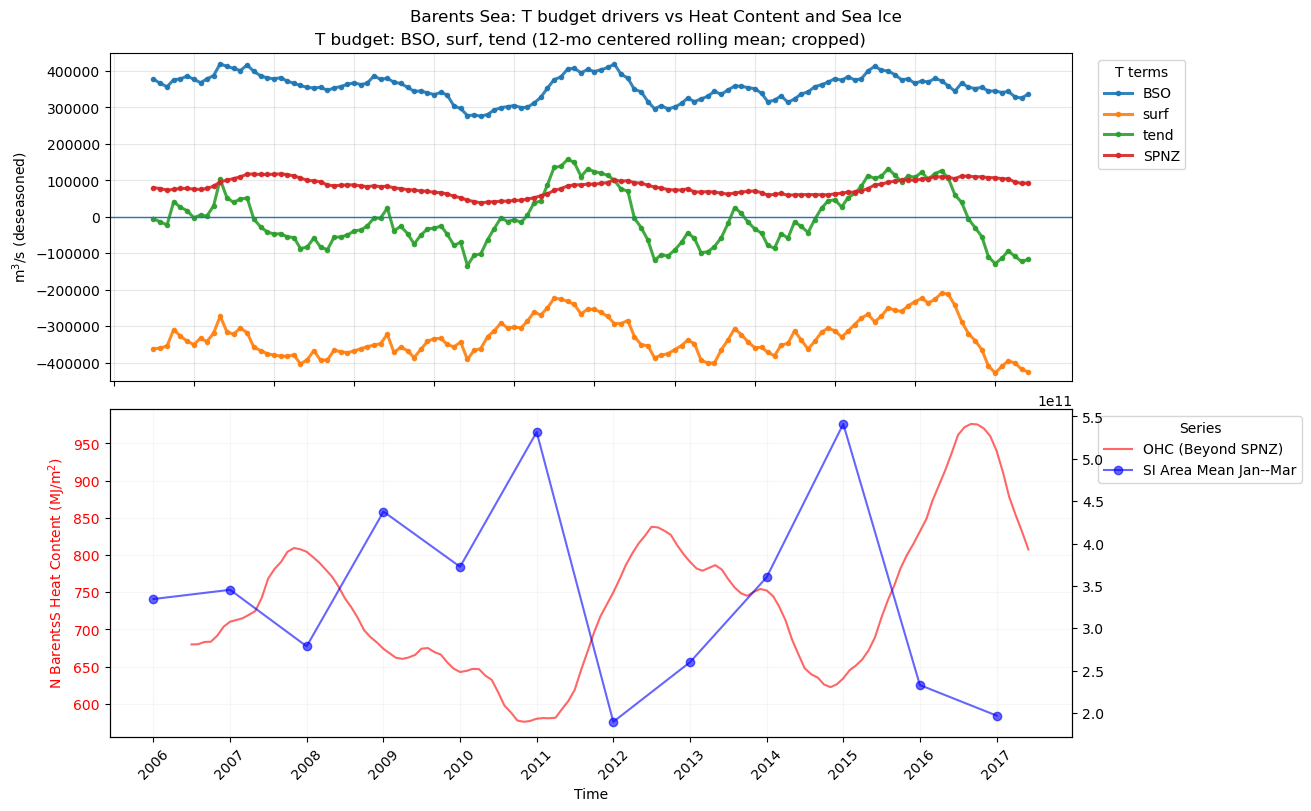

In [21]:
# plot just the long term trend for OHC and SI on this

# -------------------------------
# helpers from your pattern
# -------------------------------
def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

def collect_series(budg_name, out,drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            y.append(as_scalar(v))
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

# -------------------------------
# build time axis from out metadata
# -------------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()
ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

# collect Tbudg (drop ADVh + residuals like before, but we’ll only keep a few terms anyway)
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys, T_vals = collect_series("Tbudg",out, drop_fn=drop_terms)
T_keys2, T_vals2 = collect_series("Tbudg", outN, drop_fn=drop_terms)

# -------------------------------
# deseason via centered 12-month rolling mean (crop ends)
# -------------------------------
window_size = 12
def deseason_rolling(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    return s.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

sl = slice(6, -6)  # crop 6 months on each end

# -------------------------------
# pick the 3 T terms you want
# (adjust key strings here if yours differ)
# -------------------------------
term_map = {
    "BSO":  "BSO",
    "surf": "surf",
    "tend": "tend",   # "total tendency"
}

for want, key in term_map.items():
    if key not in T_vals:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals.keys())}")

T_plot = {name: deseason_rolling(T_vals[key], x)[sl] for name, key in term_map.items()}
x_plot = x[sl]

# also grab from the other series
term_map2 = {
    "SPNZ":  "SPNZ",
}

for want, key in term_map2.items():
    if key not in T_vals2:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals2.keys())}")

T_plot2 = {name: deseason_rolling(T_vals2[key], x)[sl] for name, key in term_map2.items()}
x_plot2 = x[sl]

# -------------------------------
# symmetric ylim helper (for the top axis)
# -------------------------------
def set_symmetric_ylim(ax, pad=1.05):
    ys = []
    for line in ax.get_lines():
        y = np.asarray(line.get_ydata(), dtype=float)
        ys.append(y[np.isfinite(y)])
    if not ys:
        return
    ymax = np.nanmax(np.abs(np.concatenate(ys)))
    if ymax == 0 or not np.isfinite(ymax):
        ymax = 1.0
    ax.set_ylim(-pad * ymax, pad * ymax)

# -------------------------------
# final figure: (1) T terms, (2) heat content + sea ice
# assumes you already have: time, heat_smoothed, SI_smoothed, eq3
# -------------------------------
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(13, 8), sharex=False, constrained_layout=True)

# --- Plot 1: T budget terms (deseasoned) ---
ax1.plot(x_plot, T_plot["BSO"],  marker=".", linewidth=2.2, alpha=0.9, label="BSO")
ax1.plot(x_plot, T_plot["surf"], marker=".", linewidth=2.2, alpha=0.9, label="surf")
ax1.plot(x_plot, T_plot["tend"], marker=".", linewidth=2.2, alpha=0.9, label="tend")
#add the SPNZ line
ax1.plot(x_plot2, T_plot2["SPNZ"], marker=".", linewidth=2.2, alpha=0.9, label="SPNZ")


ax1.axhline(0, linewidth=1)
ax1.set_ylabel("m$^3$/s (deseasoned)")
ax1.set_title("T budget: BSO, surf, tend (12-mo centered rolling mean; cropped)")
ax1.grid(alpha=0.3)
set_symmetric_ylim(ax1)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="T terms")

ax1.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate(rotation=45, ha="center")

# --- Plot 2: Heat Content and Sea Ice Area ---
# time = pd.to_datetime(time)  # ensure datetime-like
ax3.plot(x_plot, heat_smoothed[sl], color="red", alpha=0.6, label="OHC (Beyond SPNZ)")
ax3.set_ylabel("N BarentsS Heat Content (MJ/m$^2$)", color="red")
ax3.tick_params(axis="y", labelcolor="red")
ax3.grid(alpha=0.1)

ax4 = ax3.twinx()
SIarea_mean = np.asarray(SIarea_mean, dtype=float)

x_year = x[::12]  # one point per year (Jan 1 of each year)
if len(SIarea_mean) != len(x_year):
    raise ValueError(f"len(SIarea_mean)={len(SIarea_mean)} but len(x_year)={len(x_year)}")

ax4.plot(x_year, SIarea_mean,
         color="blue", alpha=0.6, marker="o", linestyle="-",
         label="SI Area Mean Jan--Mar")


# Legend for bottom plot
lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, bbox_to_anchor=(1.02, 1), loc="upper left", title="Series")

ax3.set_xlabel("Time")
ax3.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
fig.autofmt_xdate(rotation=45, ha="center")

plt.suptitle("Barents Sea: T budget drivers vs Heat Content and Sea Ice")
plt.show()

In [22]:
# I think it would also be good to define the inflow/outflow for those two important gates (ie for BSO and for FJNZ)

# cut off the edge of the Barents Sea that is should not be included
mymsk[:,84:110] = np.nan

# load the indices from file
data = np.load("/home/mmurakami/crios_backups/an_helper_functions/gates_BSO.npz")

y_bsoh, x_bsoh = data["y_bsoh"], data["x_bsoh"]
y_bsov, x_bsov = data["y_bsov"], data["x_bsov"]

y_fjnzv, x_fjnzv = data["y_fjnzv"], data["x_fjnzv"]
y_fjnz,  x_fjnz  = data["y_fjnz"],  data["x_fjnz"]

y_nzruv, x_nzruv = data["y_nzruv"], data["x_nzruv"]

y_spfjh, x_spfjh = data["y_spfjh"], data["x_spfjh"]
y_spfjv, x_spfjv = data["y_spfjv"], data["x_spfjv"]
y_spfjb, x_spfjb = data["y_spfjb"], data["x_spfjb"]

print("keys:", list(data.keys()))

keys: ['y_bsoh', 'x_bsoh', 'y_bsov', 'x_bsov', 'y_fjnzv', 'x_fjnzv', 'y_fjnz', 'x_fjnz', 'y_nzruv', 'x_nzruv', 'y_spfjh', 'x_spfjh', 'y_spfjv', 'x_spfjv', 'y_spfjb', 'x_spfjb']


## define the inflow and outflow strength at the BSO and the FJNZ gates

In [ ]:
# first figure out the gate cross section
# we will want to construct a similar 3D gate to what we did with creating the gates (maybe we can make a function)
# load a series (eg UVELMASS and VVELMASS) and create the plot

In [51]:
from adv_closure_TS import get_gates3d_volume

In [49]:
t2 = int(tsstr[5])

In [50]:
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirIn + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["UVELMASS","VVELMASS"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
UVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[0])
VVELMASS,its,meta = rdmds(os.path.join(dirIn, file_name),t2,returnmeta=True,rec=recs[1])  # m/s

In [52]:
# ADV_west, ADV_FJNZ, ADV_SPFJ, ADV_NZRU, ADV_SPNZ = get_gates3d_volume(UVELMASS,VVELMASS,mygrid,nz,ny,nx)

In [24]:
# gates = np.full((ny,nx),np.nan)
gates2 = gates.copy()

gates2[y_bsov[:-25],x_bsov[:-25]] = 6
gates2[y_fjnz[5:-10],x_fjnz[5:-10]] = 7

y_spnz = np.arange(485,560,1)
x_spnz = np.full_like(y_spnz,45) 
gates2[y_spnz,x_spnz] = 8

(400.0, 540.0)

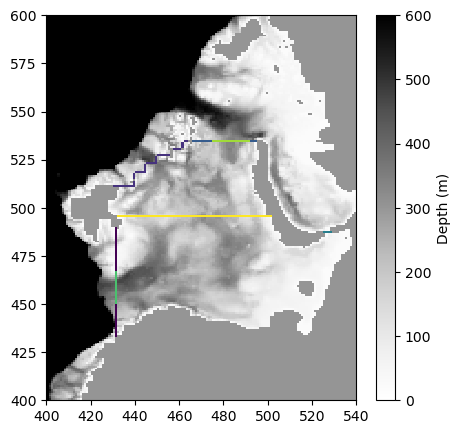

In [27]:
fig = plt.figure(figsize = (5,5))

plt.pcolormesh(get_aste_tracer(mygrid['Depth'],nfx,nfy)[0],cmap="Greys",vmin=0,vmax=600)
plt.colorbar(label="Depth (m)")
plt.pcolormesh(get_aste_tracer(gates2,nfx,nfy)[0])
plt.pcolormesh(get_aste_tracer(landmsk,nfx,nfy)[0],cmap="Greys",vmin=0,vmax=4)
plt.ylim(400,600)
plt.xlim(400,540)


In [93]:
# define these as new indices
y_bso_sel = y_bsov[:-25]
x_bso_sel = x_bsov[:-25]
y_fjnz_sel = y_fjnz[5:-10]
x_fjnz_sel = x_fjnz[5:-10]

In [94]:
def get_gates3d_volume(ADVx,ADVy,mygrid,nz,ny,nx):

    # define  the box widths and heights
    DXG3d = np.tile(mygrid['DXG'][np.newaxis,:,:],(nz,1,1))
    DYG3d = np.tile(mygrid['DYG'][np.newaxis,:,:],(nz,1,1))
    DRF3d = np.tile(mygrid['DRF'][:,np.newaxis,np.newaxis],(1,ny,nx))

    # define a function to take some ADV term and x and y, and the tracer field THETA and produce only those filled
    # define + as into the basin
    
    # --- reshape to 3D ---
    ADVx = ADVx.reshape((nz, ny, nx))   # advective heat flux on x-faces
    ADVy = ADVy.reshape((nz,ny,nx))
    
    # ---- BSO ----
    ADV_west = np.zeros((nz, ny, nx))
    # vertical faces (v-faces)
    for j, i in zip(y_bso_sel, x_bso_sel):
        # flux through y-face at (j,i) mapped into cell (j-1,i)
        ADV_west[:, j-1, i] -= ADVy[:, j, i] * DXG3d[:, j, i] * DRF3d[:, j, i]  # sign chosen so + into basin
    
    # ---- FJNZ ----
    ADV_FJNZ = np.zeros((nz, ny, nx))
    ADV_FJNZ[:,y_fjnz_sel,x_fjnz_sel[0]-1] = -ADVx[:, y_fjnz_sel, x_fjnz_sel[0]] * DYG3d[:, y_fjnz_sel, x_fjnz_sel[0]] * DRF3d[:, y_fjnz_sel, x_fjnz_sel[0]]

    return ADV_west, ADV_FJNZ

In [100]:

# ---------------------------
# helpers
# ---------------------------
def _sum_pos_neg(A):
    """Return (Q_in, Q_out_mag, Q_net) from a 3D transport field (m^3/s).
       Convention: + is into basin."""
    A = np.asarray(A, dtype=float)
    A = np.nan_to_num(A, nan=0.0)
    Qin  = float(np.sum(A[A > 0.0]))
    Qout = float(-np.sum(A[A < 0.0]))  # magnitude
    Qnet = Qin - Qout
    return Qin, Qout, Qnet

def _get_recs_for_vars(meta, varnames):
    fldlist = np.array(meta["fldList"])
    recs = []
    for v in varnames:
        idx = np.where(fldlist == v)[0]
        if len(idx) == 0:
            raise KeyError(f"{v} not in fldList. Available: {list(fldlist)}")
        recs.append(int(idx[0]))
    return recs

# ---------------------------
# FIXED: monthly loop 2006–2017, keyed by "previous month" like out[ts_key]
# ---------------------------
def compute_gate_inout_timeseries_monthly(
    years_clim, ts_by_ym, dt_by_ts,
    dirIn, mygrid, nz, ny, nx,
    get_gates3d_volume_fn,
    file_name="budg3d_hflux_set2",
    varnames=("UVELMASS", "VVELMASS"),
):
    """
    Matches your out-dict convention:
      - for each month (y,m), use ts_pair = [start_of_month, start_of_next_month]
      - store under ts_key = ts_pair[-1] (i.e., "saved under name of the previous month")
      - attaches year/month corresponding to the *previous* month (y,m)

    Returns:
      outQ[ts_key] = {
        "year": y,
        "month": m,
        "ts_pair": [ts0, ts1],
        "dt_seconds": dt,
        "gates": {
          "BSO":  {"in": Qin, "out": Qout, "net": Qnet},
          "FJNZ": {"in": Qin, "out": Qout, "net": Qnet},
          ...
        }
      }
    """
    # We will load velocities at ts_key (end-of-month label) which is exactly how your budgets are keyed.
    # If you want midpoint or mean over the month, you would need two snapshots or a time-mean product.
    # This uses the snapshot at ts_key.

    # Pick a representative ts to parse meta for record indices
    # Use first available month in the range
    y0 = int(years_clim[0])
    ts0 = ts_by_ym[(y0, 1)]
    meta0 = parsemeta(os.path.join(dirIn, f"{file_name}.{ts0}.meta"))
    recU, recV = _get_recs_for_vars(meta0, varnames)

    outQ = {}

    for y in years_clim:
        print("VOLUME YEAR", y, "done")
        for m in range(1, 13):
            # timestep pair: start-of-month to start-of-next-month
            y2, m2 = (y, m + 1) if m < 12 else (y + 1, 1)
            ts_pair = np.array([ts_by_ym[(y, m)], ts_by_ym[(y2, m2)]], dtype=object)

            dt0 = dt_by_ts[ts_pair[0]]
            dt1 = dt_by_ts[ts_pair[1]]
            dt_seconds = float((dt1 - dt0).total_seconds())

            ts_key = ts_pair[-1]  # SAME KEYING AS your out dict

            # load U/V at the ts_key (the label you store under)
            t2 = [int(ts_key)]
            U, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=recU)
            V, its, meta = rdmds(os.path.join(dirIn, file_name), t2, returnmeta=True, rec=recV)

            U = np.asarray(U).reshape((nz, ny, nx))
            V = np.asarray(V).reshape((nz, ny, nx))

            gates = get_gates3d_volume_fn(U, V, mygrid, nz, ny, nx)

            if len(gates) == 2:
                gate_names = ["BSO", "FJNZ"]
            elif len(gates) == 5:
                gate_names = ["BSO", "FJNZ", "SPFJ", "NZRU", "SPNZ"]
            else:
                gate_names = [f"gate{i}" for i in range(len(gates))]

            outQ[str(ts_key)] = {
                "year": int(y),
                "month": int(m),          # month being summarized (previous month)
                "ts_pair": list(ts_pair), # [start, end]
                "dt_seconds": dt_seconds,
                "gates": {}
            }

            for gname, A3d in zip(gate_names, gates):
                Qin, Qout, Qnet = _sum_pos_neg(A3d)
                outQ[str(ts_key)]["gates"][gname] = {"in": Qin, "out": Qout, "net": Qnet}

    print(y0)

    return outQ


# ---------------------------
# USAGE: plug into your existing mapping (ts_by_ym, dt_by_ts)
# ---------------------------
years_clim = np.arange(2006, 2018)

years_clim = np.arange(2006, 2018)          # 2006..2017 (inclusive)
years_req  = np.arange(2006, 2019)          # 2006..2018 (need Jan 2018)

times = {str(y): np.arange(1, 13) for y in years_req}
times[str(2018)] = np.array([1])            # only Jan 2018 needed

tsstr_sel, dts_sel = get_tsteps(times, fnames, dt_aste, startyr, 1, 1)
tindex = pd.DatetimeIndex(dts_sel)
tsstr_sel = np.asarray(tsstr_sel)
dt_by_ts = {ts: dt for ts, dt in zip(tsstr_sel, tindex)}  # for the correct dt

# Map (year, month) -> tsstr (string)
ts_by_ym = {(dt.year, dt.month): ts for dt, ts in zip(tindex, tsstr_sel)}

outQ = compute_gate_inout_timeseries_monthly(
    years_clim=years_clim,
    ts_by_ym=ts_by_ym,
    dt_by_ts=dt_by_ts,
    dirIn=dirIn,
    mygrid=mygrid, nz=nz, ny=ny, nx=nx,
    get_gates3d_volume_fn=get_gates3d_volume,
    file_name="budg3d_hflux_set2",
    varnames=("UVELMASS","VVELMASS"),
)
#
# Now outQ is keyed exactly like out: outQ[ts_key] has year/month for the previous month.
# Example:
# ts_key = list(outQ.keys())[0]
# outQ[ts_key]["gates"]["BSO"]["in"], outQ[ts_key]["gates"]["BSO"]["out"]


VOLUME YEAR 2006 done
VOLUME YEAR 2007 done
VOLUME YEAR 2008 done
VOLUME YEAR 2009 done
VOLUME YEAR 2010 done
VOLUME YEAR 2011 done
VOLUME YEAR 2012 done
VOLUME YEAR 2013 done
VOLUME YEAR 2014 done
VOLUME YEAR 2015 done
VOLUME YEAR 2016 done
VOLUME YEAR 2017 done
2006


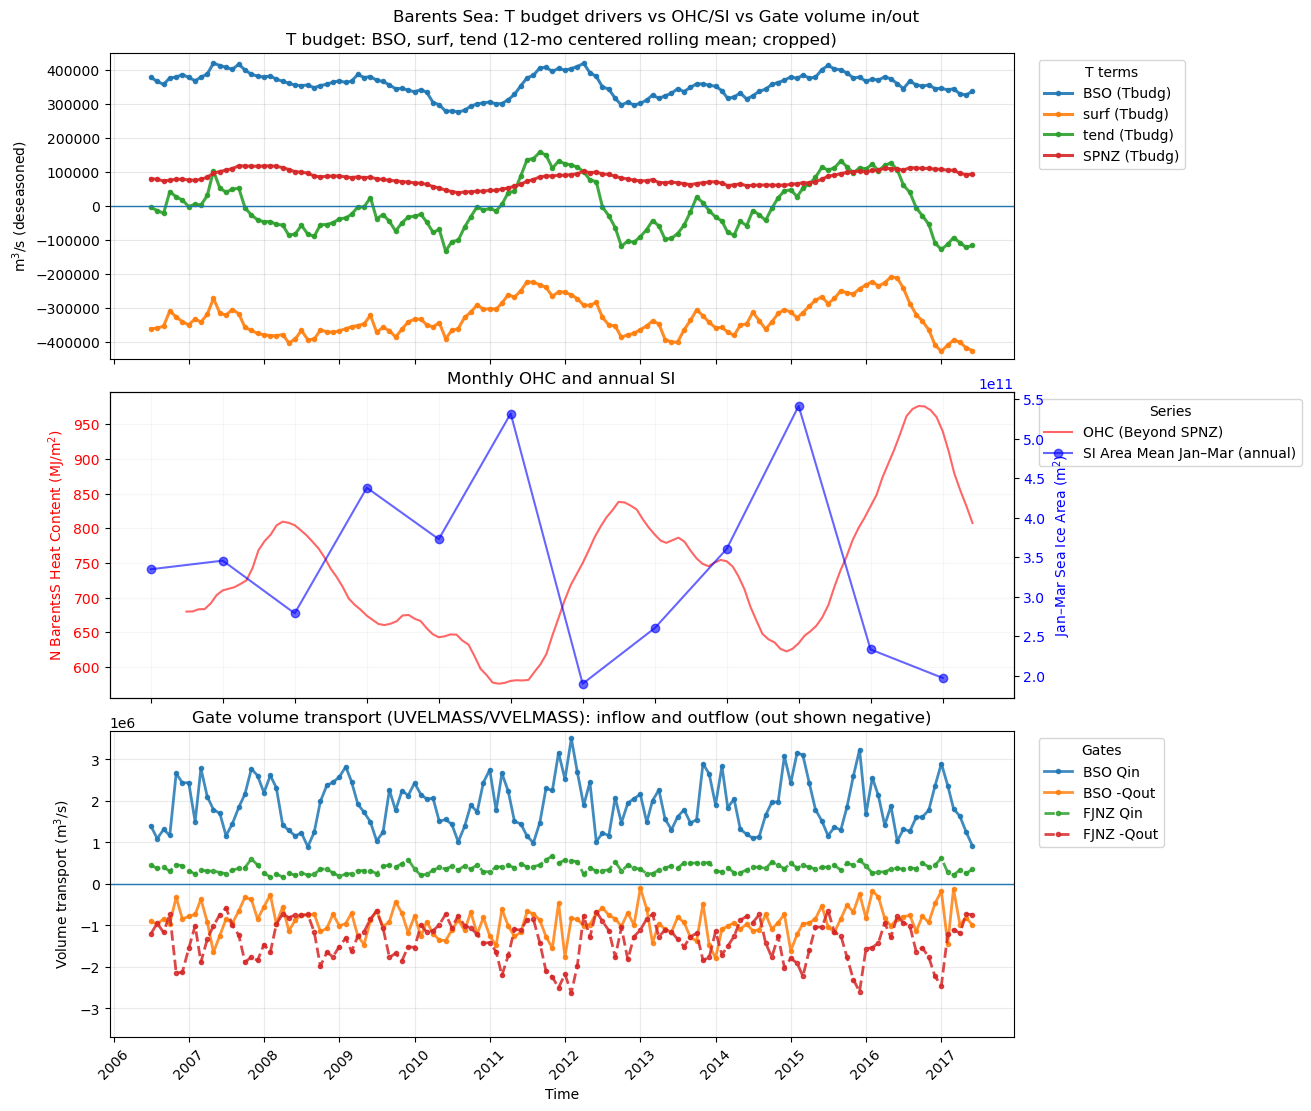

In [101]:

# -------------------------------
# helpers from your pattern
# -------------------------------
def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

def collect_series(budg_name, out, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            y.append(as_scalar(v))
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

def set_symmetric_ylim(ax, pad=1.05):
    ys = []
    for line in ax.get_lines():
        y = np.asarray(line.get_ydata(), dtype=float)
        ys.append(y[np.isfinite(y)])
    if not ys:
        return
    ymax = np.nanmax(np.abs(np.concatenate(ys)))
    if ymax == 0 or not np.isfinite(ymax):
        ymax = 1.0
    ax.set_ylim(-pad * ymax, pad * ymax)

# -------------------------------
# build time axis from out metadata
# -------------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()
ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

# collect Tbudg terms
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys,  T_vals  = collect_series("Tbudg", out,  drop_fn=drop_terms)
T_keys2, T_vals2 = collect_series("Tbudg", outN, drop_fn=drop_terms)

# -------------------------------
# deseason via centered 12-month rolling mean (crop ends)
# -------------------------------
window_size = 12
def deseason_rolling(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    return s.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

sl = slice(6, -6)
x_plot  = x[sl]
x_plot2 = x[sl]

# terms you want in top panel
term_map = {"BSO":"BSO", "surf":"surf", "tend":"tend"}
for _, key in term_map.items():
    if key not in T_vals:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals.keys())}")
T_plot = {name: deseason_rolling(T_vals[key], x)[sl] for name, key in term_map.items()}

# SPNZ from other dictionary
term_map2 = {"SPNZ":"SPNZ"}
for _, key in term_map2.items():
    if key not in T_vals2:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals2.keys())}")
T_plot2 = {name: deseason_rolling(T_vals2[key], x)[sl] for name, key in term_map2.items()}

# -------------------------------
# Plot 3 data: volume in/out from outQ (two gates)
# -------------------------------
# outQ keyed by tsstr strings; align to ts_sorted and same crop slice
gateA = "BSO"
gateB = "FJNZ"

def _get_gate_series(outQ, ts_list, gate, field):
    y = []
    for ts in ts_list:
        dd = outQ.get(str(ts), {}).get("gates", {}).get(gate, {})
        y.append(dd.get(field, np.nan))
    return np.asarray(y, dtype=float)

Qin_A  = _get_gate_series(outQ, ts_sorted, gateA, "in")[sl]
Qout_A = _get_gate_series(outQ, ts_sorted, gateA, "out")[sl]
Qin_B  = _get_gate_series(outQ, ts_sorted, gateB, "in")[sl]
Qout_B = _get_gate_series(outQ, ts_sorted, gateB, "out")[sl]

# -------------------------------
# final figure: 3 panels
# -------------------------------
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, figsize=(13, 11), sharex=False, constrained_layout=True)

# --- Plot 1: T budget terms (deseasoned) ---
ax1.plot(x_plot,  T_plot["BSO"],  marker=".", linewidth=2.2, alpha=0.9, label="BSO (Tbudg)")
ax1.plot(x_plot,  T_plot["surf"], marker=".", linewidth=2.2, alpha=0.9, label="surf (Tbudg)")
ax1.plot(x_plot,  T_plot["tend"], marker=".", linewidth=2.2, alpha=0.9, label="tend (Tbudg)")
ax1.plot(x_plot2, T_plot2["SPNZ"], marker=".", linewidth=2.2, alpha=0.9, label="SPNZ (Tbudg)")

ax1.axhline(0, linewidth=1)
ax1.set_ylabel("m$^3$/s (deseasoned)")
ax1.set_title("T budget: BSO, surf, tend (12-mo centered rolling mean; cropped)")
ax1.grid(alpha=0.3)
set_symmetric_ylim(ax1)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="T terms")
ax1.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# --- Plot 2: Monthly OHC + annual SI (dual axis) ---
ax3.plot(x_plot, np.asarray(heat_smoothed, dtype=float)[sl], color="red", alpha=0.6, label="OHC (Beyond SPNZ)")
ax3.set_ylabel("N BarentsS Heat Content (MJ/m$^2$)", color="red")
ax3.tick_params(axis="y", labelcolor="red")
ax3.grid(alpha=0.1)

ax4 = ax3.twinx()
SIarea_mean = np.asarray(SIarea_mean, dtype=float)
x_year = x[::12]
if len(SIarea_mean) != len(x_year):
    raise ValueError(f"len(SIarea_mean)={len(SIarea_mean)} but len(x_year)={len(x_year)}")
ax4.plot(x_year, SIarea_mean, color="blue", alpha=0.6, marker="o", linestyle="-",
         label="SI Area Mean Jan–Mar (annual)")
ax4.set_ylabel("Jan–Mar Sea Ice Area (m$^2$)", color="blue")
ax4.tick_params(axis="y", labelcolor="blue")

lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, bbox_to_anchor=(1.02, 1),
          loc="upper left", title="Series")
ax3.set_title("Monthly OHC and annual SI")
ax3.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# --- Plot 3: Volume transport in/out at gates (from outQ) ---
# plot inflow positive, outflow as negative for visual symmetry
ax5.plot(x_plot,  Qin_A,  marker=".", linewidth=2.0, alpha=0.85, label=f"{gateA} Qin")
ax5.plot(x_plot, -Qout_A, marker=".", linewidth=2.0, alpha=0.85, label=f"{gateA} -Qout")
ax5.plot(x_plot,  Qin_B,  marker=".", linewidth=2.0, alpha=0.85, linestyle="--", label=f"{gateB} Qin")
ax5.plot(x_plot, -Qout_B, marker=".", linewidth=2.0, alpha=0.85, linestyle="--", label=f"{gateB} -Qout")

ax5.axhline(0, linewidth=1)
ax5.set_ylabel("Volume transport (m$^3$/s)")
ax5.set_title("Gate volume transport (UVELMASS/VVELMASS): inflow and outflow (out shown negative)")
ax5.grid(alpha=0.25)
set_symmetric_ylim(ax5)
ax5.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Gates")

ax5.set_xlabel("Time")
ax5.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax5.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate(rotation=45, ha="center")
plt.suptitle("Barents Sea: T budget drivers vs OHC/SI vs Gate volume in/out")
plt.show()


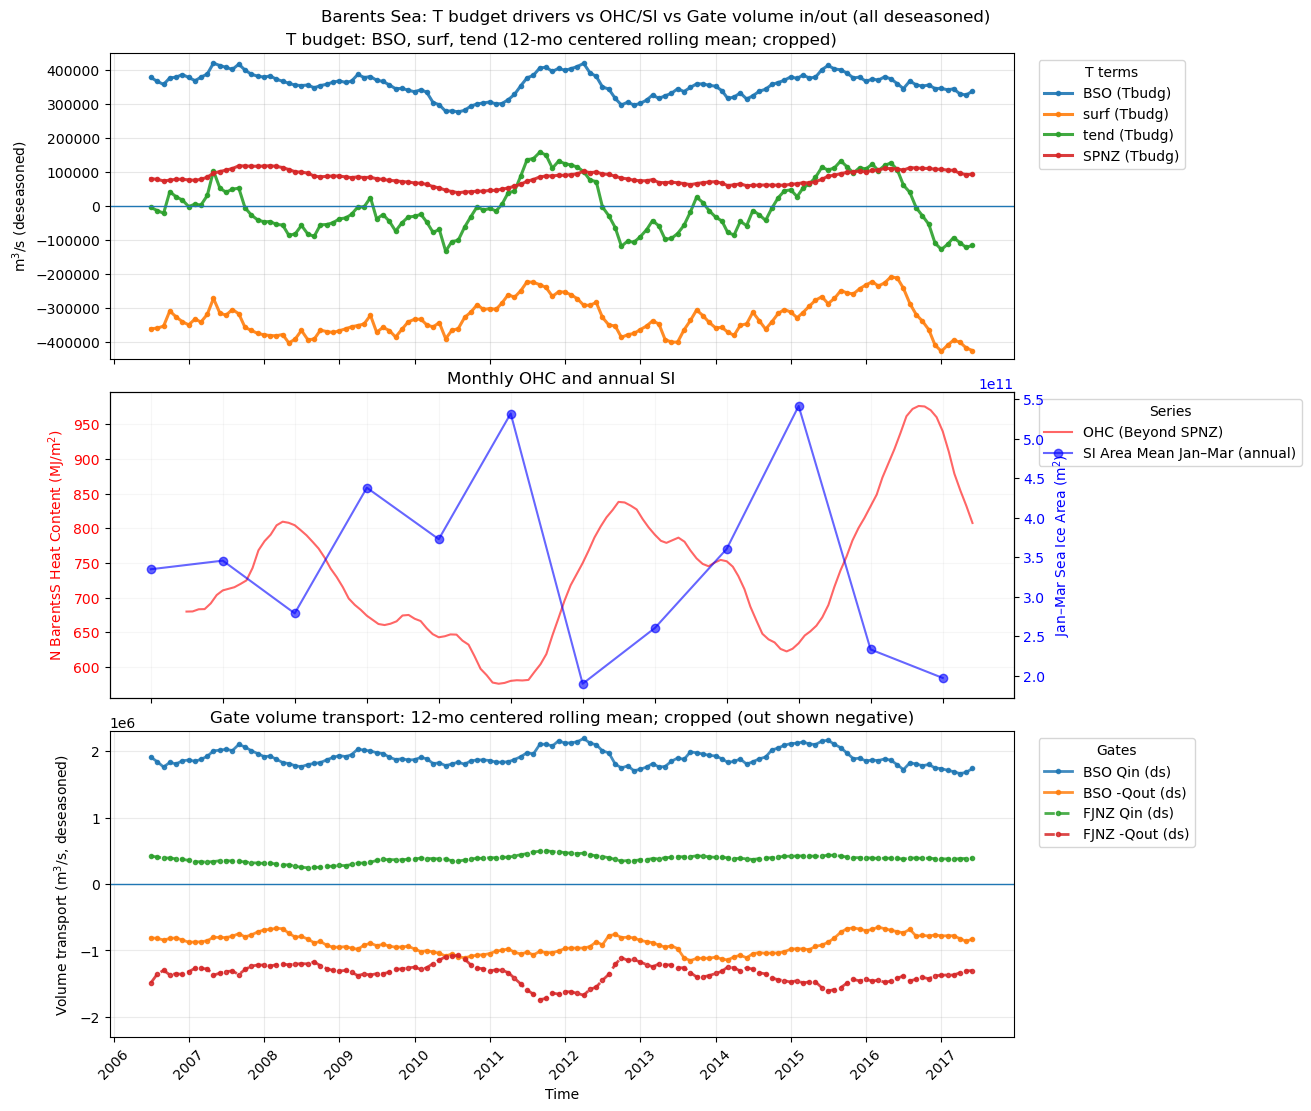

In [102]:

# -------------------------------
# helpers from your pattern
# -------------------------------
def _norm_key(k):
    return str(k).lower().replace(" ", "").replace("_", "")

def is_advh(k):
    return "advh" in _norm_key(k)

def is_residual(k):
    s = _norm_key(k)
    return ("resid" in s) or ("residual" in s)

def as_scalar(v):
    v = np.asarray(v)
    return float(np.nansum(v)) if v.ndim else float(v)

def collect_series(budg_name, out, drop_fn=None):
    all_keys = sorted({k for ts in ts_sorted for k in out[ts].get(budg_name, {}).keys()})
    if drop_fn is not None:
        all_keys = [k for k in all_keys if not drop_fn(k)]

    vals_by_key = {}
    for k in all_keys:
        y = []
        for ts in ts_sorted:
            v = out[ts].get(budg_name, {}).get(k, np.nan)
            y.append(as_scalar(v))
        vals_by_key[k] = np.asarray(y, dtype=float)
    return all_keys, vals_by_key

def set_symmetric_ylim(ax, pad=1.05):
    ys = []
    for line in ax.get_lines():
        y = np.asarray(line.get_ydata(), dtype=float)
        ys.append(y[np.isfinite(y)])
    if not ys:
        return
    ymax = np.nanmax(np.abs(np.concatenate(ys)))
    if ymax == 0 or not np.isfinite(ymax):
        ymax = 1.0
    ax.set_ylim(-pad * ymax, pad * ymax)

# -------------------------------
# build time axis from out metadata
# -------------------------------
ts_names = list(out.keys())
triples = [(out[ts]["year"], out[ts]["month"], ts) for ts in ts_names]
triples.sort()
ts_sorted = [ts for (_, _, ts) in triples]
x = pd.to_datetime([f"{y:04d}-{m:02d}-01" for (y, m, _) in triples])

# collect Tbudg terms
drop_terms = lambda k: is_advh(k) or is_residual(k)
T_keys,  T_vals  = collect_series("Tbudg", out,  drop_fn=drop_terms)
T_keys2, T_vals2 = collect_series("Tbudg", outN, drop_fn=drop_terms)

# -------------------------------
# deseason via centered 12-month rolling mean (crop ends)
# -------------------------------
window_size = 12
def deseason_rolling(y, x_index):
    s = pd.Series(np.asarray(y, dtype=float), index=x_index)
    return s.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()

sl = slice(6, -6)
x_plot  = x[sl]
x_plot2 = x[sl]

# top panel terms
term_map = {"BSO":"BSO", "surf":"surf", "tend":"tend"}
for _, key in term_map.items():
    if key not in T_vals:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals.keys())}")
T_plot = {name: deseason_rolling(T_vals[key], x)[sl] for name, key in term_map.items()}

# SPNZ from other dictionary
term_map2 = {"SPNZ":"SPNZ"}
for _, key in term_map2.items():
    if key not in T_vals2:
        raise KeyError(f"Tbudg missing key '{key}'. Available keys: {list(T_vals2.keys())}")
T_plot2 = {name: deseason_rolling(T_vals2[key], x)[sl] for name, key in term_map2.items()}

# -------------------------------
# Plot 3 data: volume in/out from outQ (two gates) + DESEASON
# -------------------------------
gateA = "BSO"
gateB = "FJNZ"

def _get_gate_series(outQ, ts_list, gate, field):
    y = []
    for ts in ts_list:
        dd = outQ.get(str(ts), {}).get("gates", {}).get(gate, {})
        y.append(dd.get(field, np.nan))
    return np.asarray(y, dtype=float)

# raw monthly series (aligned to x)
Qin_A_raw  = _get_gate_series(outQ, ts_sorted, gateA, "in")
Qout_A_raw = _get_gate_series(outQ, ts_sorted, gateA, "out")
Qin_B_raw  = _get_gate_series(outQ, ts_sorted, gateB, "in")
Qout_B_raw = _get_gate_series(outQ, ts_sorted, gateB, "out")

# deseason like the top: 12-mo centered rolling mean, then crop
Qin_A  = deseason_rolling(Qin_A_raw,  x)[sl]
Qout_A = deseason_rolling(Qout_A_raw, x)[sl]
Qin_B  = deseason_rolling(Qin_B_raw,  x)[sl]
Qout_B = deseason_rolling(Qout_B_raw, x)[sl]

# -------------------------------
# final figure: 3 panels
# -------------------------------
fig, (ax1, ax3, ax5) = plt.subplots(3, 1, figsize=(13, 11), sharex=False, constrained_layout=True)

# --- Plot 1: T budget terms (deseasoned) ---
ax1.plot(x_plot,  T_plot["BSO"],  marker=".", linewidth=2.2, alpha=0.9, label="BSO (Tbudg)")
ax1.plot(x_plot,  T_plot["surf"], marker=".", linewidth=2.2, alpha=0.9, label="surf (Tbudg)")
ax1.plot(x_plot,  T_plot["tend"], marker=".", linewidth=2.2, alpha=0.9, label="tend (Tbudg)")
ax1.plot(x_plot2, T_plot2["SPNZ"], marker=".", linewidth=2.2, alpha=0.9, label="SPNZ (Tbudg)")

ax1.axhline(0, linewidth=1)
ax1.set_ylabel("m$^3$/s (deseasoned)")
ax1.set_title("T budget: BSO, surf, tend (12-mo centered rolling mean; cropped)")
ax1.grid(alpha=0.3)
set_symmetric_ylim(ax1)
ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="T terms")
ax1.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# --- Plot 2: Monthly OHC + annual SI (dual axis) ---
ax3.plot(x_plot, np.asarray(heat_smoothed, dtype=float)[sl], color="red", alpha=0.6, label="OHC (Beyond SPNZ)")
ax3.set_ylabel("N BarentsS Heat Content (MJ/m$^2$)", color="red")
ax3.tick_params(axis="y", labelcolor="red")
ax3.grid(alpha=0.1)

ax4 = ax3.twinx()
SIarea_mean = np.asarray(SIarea_mean, dtype=float)
x_year = x[::12]
if len(SIarea_mean) != len(x_year):
    raise ValueError(f"len(SIarea_mean)={len(SIarea_mean)} but len(x_year)={len(x_year)}")
ax4.plot(x_year, SIarea_mean, color="blue", alpha=0.6, marker="o", linestyle="-",
         label="SI Area Mean Jan–Mar (annual)")
ax4.set_ylabel("Jan–Mar Sea Ice Area (m$^2$)", color="blue")
ax4.tick_params(axis="y", labelcolor="blue")

lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, bbox_to_anchor=(1.02, 1),
          loc="upper left", title="Series")
ax3.set_title("Monthly OHC and annual SI")
ax3.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# --- Plot 3: Gate volume transport (DESEASONED like Plot 1) ---
# show outflow as negative for symmetry
ax5.plot(x_plot,  Qin_A,  marker=".", linewidth=2.0, alpha=0.85, label=f"{gateA} Qin (ds)")
ax5.plot(x_plot, -Qout_A, marker=".", linewidth=2.0, alpha=0.85, label=f"{gateA} -Qout (ds)")
ax5.plot(x_plot,  Qin_B,  marker=".", linewidth=2.0, alpha=0.85, linestyle="--", label=f"{gateB} Qin (ds)")
ax5.plot(x_plot, -Qout_B, marker=".", linewidth=2.0, alpha=0.85, linestyle="--", label=f"{gateB} -Qout (ds)")

ax5.axhline(0, linewidth=1)
ax5.set_ylabel("Volume transport (m$^3$/s, deseasoned)")
ax5.set_title("Gate volume transport: 12-mo centered rolling mean; cropped (out shown negative)")
ax5.grid(alpha=0.25)
set_symmetric_ylim(ax5)
ax5.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Gates")

ax5.set_xlabel("Time")
ax5.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax5.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

fig.autofmt_xdate(rotation=45, ha="center")
plt.suptitle("Barents Sea: T budget drivers vs OHC/SI vs Gate volume in/out (all deseasoned)")
plt.show()
